In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *

### Bivariate Normal Data Generation

In [198]:
from simulation import get_sampler, cls_to_dset, get_train_test_samples
MU = {
    0: [2, 2],
    1: [4, 1],
    2: [3, 5],
    3: [6, 3]
}
std = 0.2
COV = {
    0: np.eye(2)*std**2,
    1: np.eye(2)*std**2,
    2: np.eye(2)*std**2,
    3: np.eye(2)*std**2
}
K = 4
SAMPLERS = get_sampler(MU, COV, K)
# Get SAMPLES
n = 100
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_train_test_samples(SAMPLERS=SAMPLERS, n=n)
# Dataset
IND_CLS = [0, 1, 2]
OOD_CLS = [3]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)

#### Plot

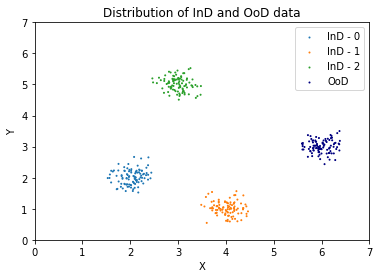

In [199]:
for idx in IND_CLS:
    plt.scatter(IND_X[:,0][IND_Y==idx], IND_X[:,1][IND_Y==idx], label =f"InD - {idx}", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

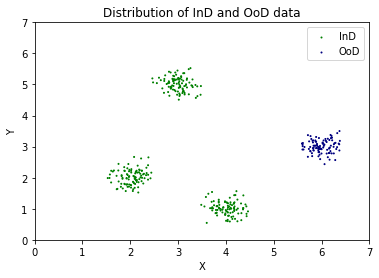

In [200]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

### Naive Classifier Training

In [201]:
from tqdm import tqdm
from simulation import classifier_training
D = DSIM()
# Configuration
max_epoch = 100
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)
torch.save(D.state_dict(), "simulation_log/model/D.pt")

 11%|█         | 11/100 [00:00<00:00, 106.32it/s]

Epoch  # 1 | Tri loss: 1.1004                     | Tri accuracy: 0.3459
Epoch  # 1 | Val loss: 1.046                     | Val accuracy: 0.3365


 67%|██████▋   | 67/100 [00:00<00:00, 127.73it/s]

Epoch  # 51 | Tri loss: 0.0624                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.0662                     | Val accuracy: 1.0


100%|██████████| 100/100 [00:00<00:00, 124.94it/s]


#### Plot

In [202]:
xi = np.linspace(0, 8, 100, endpoint=True)
yi = np.linspace(0, 8, 100, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
x, y = np.concatenate((IND_X[:,0],OOD_X[:,0])), np.concatenate((IND_X[:,1],OOD_X[:,1]))
zi = torch.softmax(D(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([10000, 3])


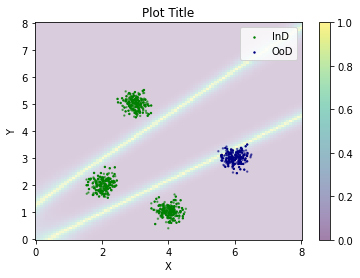

In [204]:
from wasserstein import *
plt.pcolormesh(xi, yi, si.reshape((100, 100)).T, shading='auto', cmap="viridis", alpha=0.2)
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[2]*len(IND_X), alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", sizes=[2]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0], IND_X_TEST[:,1], c='green', sizes=[2]*len(IND_X), alpha=0.50)
plt.scatter(OOD_X_TEST[:,0], OOD_X_TEST[:,1], c='navy', sizes=[2]*len(OOD_X), alpha=0.50)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.colorbar()
plt.savefig("heatmap.jpg", dpi=1000)
plt.show()

### WOOD Training

In [205]:
from simulation import *
D_WOOD = DSIM()
# OOD data preparation
n_ood = 4
ood_bsz = 4
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
torch.save(OOD_BATCH, "simulation_log/model/ood_batch.pt")
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 100
lr = 1e-3
beta = 0.1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)

OOD Batch Shape: torch.Size([4, 2])


  1%|          | 1/100 [00:00<00:13,  7.30it/s]

Epoch  # 1 | Tri loss: 1.04                     | Tri accuracy: 0.4178
Epoch  # 1 | Val loss: 1.0682                     | Val accuracy: 0.6483


 52%|█████▏    | 52/100 [00:04<00:04, 11.81it/s]

Epoch  # 51 | Tri loss: 0.4293                     | Tri accuracy: 0.9577
Epoch  # 51 | Val loss: 0.4432                     | Val accuracy: 0.9922


100%|██████████| 100/100 [00:08<00:00, 11.33it/s]


In [209]:
m = 100
xi = np.linspace(0, 8, m, endpoint=True)
yi = np.linspace(0, 8, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_WOOD(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([10000, 3])


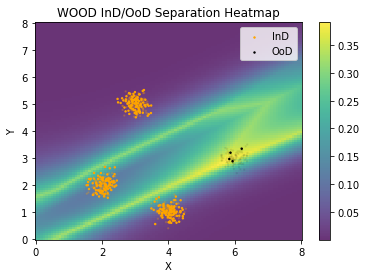

In [228]:
from wasserstein import *
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto', alpha=0.8)
plt.colorbar()
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", sizes=[2]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='black', label="OoD", sizes=[2]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0], IND_X_TEST[:,1], c='orange', sizes=[2]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='black', sizes=[2]*len(OOD_X), alpha=0.05)
plt.title("WOOD InD/OoD Separation Heatmap")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.savefig("simulation_log/plot/wood_heatmap.jpg", dpi=1000)
plt.show()

torch.Size([2500, 3])


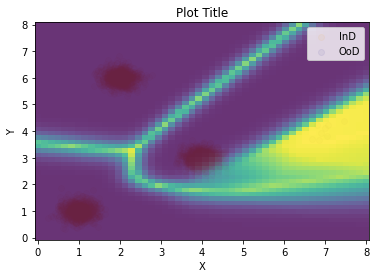

In [49]:
# 8
from wasserstein import *
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.05)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=0.05)
xi = np.linspace(0, 8, 50, endpoint=True)
yi = np.linspace(0, 8, 50, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_WOOD(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
plt.pcolormesh(xi, yi, si.reshape((50,50)).T, shading='auto', alpha=0.8)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

torch.Size([2500, 3])


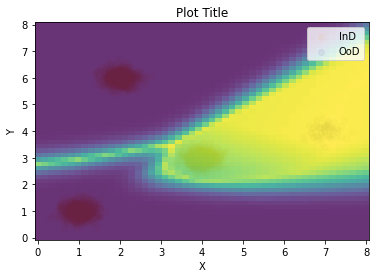

In [42]:
# 64
from wasserstein import *
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.05)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=0.05)
xi = np.linspace(0, 8, 50, endpoint=True)
yi = np.linspace(0, 8, 50, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_WOOD(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
plt.pcolormesh(xi, yi, si.reshape((50,50)).T, shading='auto', alpha=0.8)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

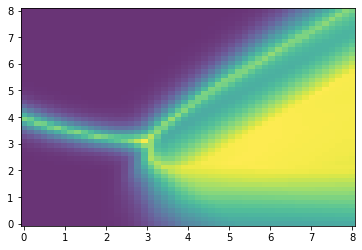

In [26]:
# 1000
plt.pcolormesh(xi, yi, si.reshape((50,50)).T, shading='auto', alpha=0.8)

### OOD GAN Training

In [251]:
from simulation import *
D_GAN = DSIM()
G_GAN = GSIM()
# OOD data preparation
# n_ood = 64
ood_bsz = 64
bsz_tri = 64
# OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 256
lr = 1e-3
w_ce, w_wass = 1, 0.1
n_dim = 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, \
                    ind_tri_loader, ind_val_loader, max_epoch, n_epoch=5, n_step_log=10)

OOD Batch Shape: torch.Size([4, 2])


  0%|          | 0/256 [00:00<?, ?it/s]

Step: 0    | D:  1.1977 | CE:  1.1754 | W_OoD:  1.8202 | W_z:  0.9554 | G:  4.6139 | W_z:  0.9391 | dist: 4.5749


  0%|          | 1/256 [00:04<18:58,  4.46s/it]

Epoch  # 1 | Val accuracy: 0.3553


  2%|▏         | 5/256 [00:23<19:19,  4.62s/it]

Step: 0    | D:  1.0271 | CE:  1.0213 | W_OoD:  1.0987 | W_z:  0.9390 | G:  3.9761 | W_z:  0.9373 | dist: 3.9370


  2%|▏         | 6/256 [00:27<19:06,  4.59s/it]

Epoch  # 6 | Val accuracy: 0.475


  4%|▍         | 10/256 [00:45<18:28,  4.51s/it]

Step: 0    | D:  0.9528 | CE:  0.9478 | W_OoD:  1.0746 | W_z:  0.9372 | G:  3.0574 | W_z:  0.9377 | dist: 3.0182


  4%|▍         | 11/256 [00:50<18:21,  4.50s/it]

Epoch  # 11 | Val accuracy: 0.6635


  6%|▌         | 15/256 [01:08<18:27,  4.60s/it]

Step: 0    | D:  1.0209 | CE:  1.0193 | W_OoD:  0.9860 | W_z:  0.9457 | G:  1.6750 | W_z:  0.9458 | dist: 1.6362


  6%|▋         | 16/256 [01:13<18:18,  4.58s/it]

Epoch  # 16 | Val accuracy: 0.3572


  8%|▊         | 20/256 [01:31<18:03,  4.59s/it]

Step: 0    | D:  1.1148 | CE:  1.1117 | W_OoD:  1.0296 | W_z:  0.9454 | G:  0.4152 | W_z:  0.9611 | dist: 0.3770


  8%|▊         | 21/256 [01:36<18:18,  4.67s/it]

Epoch  # 21 | Val accuracy: 0.3271


 10%|▉         | 25/256 [01:55<17:31,  4.55s/it]

Step: 0    | D:  1.1264 | CE:  1.1257 | W_OoD:  0.9863 | W_z:  0.9688 | G:  0.1699 | W_z:  0.9491 | dist: 0.1312


 10%|█         | 26/256 [01:59<17:45,  4.63s/it]

Epoch  # 26 | Val accuracy: 0.3176


 12%|█▏        | 30/256 [02:19<17:46,  4.72s/it]

Step: 0    | D:  1.1308 | CE:  1.1302 | W_OoD:  0.9702 | W_z:  0.9536 | G:  0.0537 | W_z:  0.9542 | dist: 0.0152


 12%|█▏        | 31/256 [02:23<17:24,  4.64s/it]

Epoch  # 31 | Val accuracy: 0.2894


 14%|█▎        | 35/256 [02:41<16:44,  4.55s/it]

Step: 0    | D:  1.1023 | CE:  1.1015 | W_OoD:  0.9598 | W_z:  0.9410 | G:  0.0687 | W_z:  0.9528 | dist: 0.0302


 14%|█▍        | 36/256 [02:46<16:44,  4.56s/it]

Epoch  # 36 | Val accuracy: 0.3398


 16%|█▌        | 40/256 [03:04<16:13,  4.51s/it]

Step: 0    | D:  1.0872 | CE:  1.0871 | W_OoD:  0.9439 | W_z:  0.9421 | G:  0.0716 | W_z:  0.9436 | dist: 0.0326


 16%|█▌        | 41/256 [03:08<16:18,  4.55s/it]

Epoch  # 41 | Val accuracy: 0.4022


 18%|█▊        | 45/256 [03:27<16:04,  4.57s/it]

Step: 0    | D:  1.0747 | CE:  1.0744 | W_OoD:  0.9463 | W_z:  0.9391 | G:  0.0738 | W_z:  0.9400 | dist: 0.0347


 18%|█▊        | 46/256 [03:32<16:48,  4.80s/it]

Epoch  # 46 | Val accuracy: 0.5297


 20%|█▉        | 50/256 [03:51<16:02,  4.67s/it]

Step: 0    | D:  1.0531 | CE:  1.0530 | W_OoD:  0.9454 | W_z:  0.9425 | G:  0.0733 | W_z:  0.9416 | dist: 0.0343


 20%|█▉        | 51/256 [03:55<15:55,  4.66s/it]

Epoch  # 51 | Val accuracy: 0.6447


 20%|██        | 52/256 [04:00<16:09,  4.75s/it]

In [243]:
m = 100
xi = np.linspace(0, 8, m, endpoint=True)
yi = np.linspace(0, 8, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_GAN(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([10000, 3])


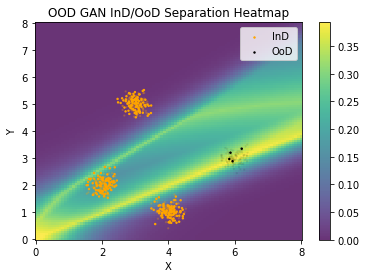

In [244]:
from wasserstein import *
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto', alpha=0.8)
plt.colorbar()
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", sizes=[2]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='black', label="OoD", sizes=[2]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0], IND_X_TEST[:,1], c='orange', sizes=[2]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='black', sizes=[2]*len(OOD_X), alpha=0.05)
plt.title("OOD GAN InD/OoD Separation Heatmap")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.savefig("simulation_log/plot/oodgan_heatmap0.jpg", dpi=1000)
plt.show()

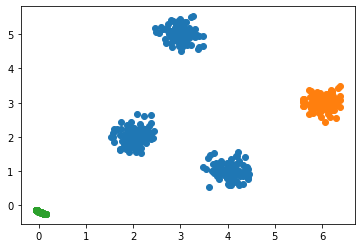

In [237]:
seed = torch.rand((128, 1))
gz = G_GAN(seed).detach().numpy()
plt.scatter(IND_X[:,0], IND_X[:,1])
plt.scatter(OOD_X[:,0], OOD_X[:,1])
plt.scatter(gz[:,0], gz[:,1])
plt.show()

In [238]:
z = torch.softmax(D_GAN(torch.tensor(IND_X, dtype=torch.float32)), dim=-1)
print(z.shape)
s = ood_wass_loss(z)
print(s.shape)

torch.Size([300, 3])
torch.Size([300])


In [239]:
threshold = np.quantile(s, 0.95)
print(threshold)
z_ood = torch.softmax(D_GAN(torch.tensor(OOD_X, dtype=torch.float32)), dim=-1)
print(z_ood.shape)
s_ood = ood_wass_loss(z_ood)

0.27763318419456484
torch.Size([100, 3])


In [240]:
tpr = sum(s_ood > threshold) / len(s_ood)
print(tpr)

tensor(0.9700)


torch.Size([250000, 3])


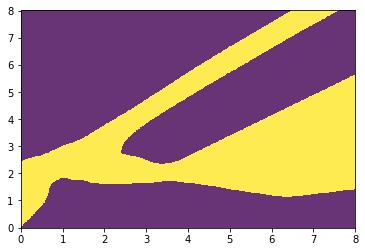

In [89]:
m = 500
xi = np.linspace(0, 8, m, endpoint=True)
yi = np.linspace(0, 8, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_GAN(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
mask = si > threshold
plt.pcolormesh(xi, yi, mask.reshape((m,m)).T, shading='auto', alpha=0.8)

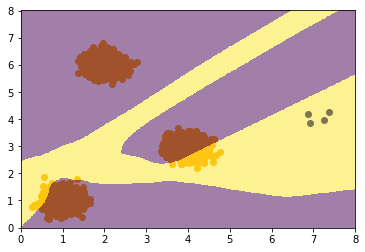

In [90]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=1)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=1)
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto', alpha=0.5)

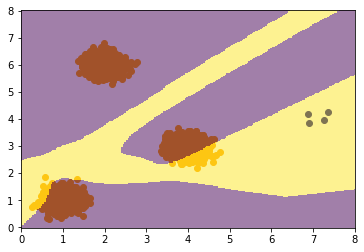

In [88]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=1)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=1)
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto', alpha=0.5)